In [72]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy import signal

In [2]:
file_name = "TesteAudio.wav"
samples, sampling_rate = librosa.load(file_name, sr = None, mono = True, offset = 0.0, duration = None)
len(samples), sampling_rate

(108161, 16000)

In [3]:
from IPython.display import Audio
Audio(file_name)

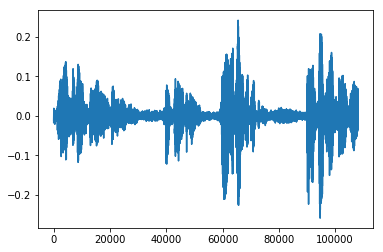

In [4]:
plt.plot(samples)

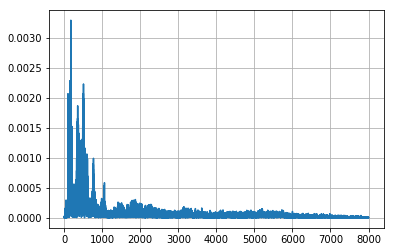

In [5]:
T = 1/sampling_rate
N = len(samples)

yf = scipy.fft(samples)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [8]:
#https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520
def spectrogram(samples, sample_rate, max_freq = 20000, stride_ms = 10.0, 
                          window_ms = 20.0, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [9]:
test_spec = spectrogram(samples, sampling_rate)

In [10]:
test_spec.shape

(161, 675)

In [38]:
stride_ms = 10.0
window_ms = 20.0
stride_size = int(0.001 * sampling_rate * stride_ms)
window_size = int(0.001 * sampling_rate * window_ms)
overlap_size = window_size // 2
f, t, Sxx = signal.spectrogram(samples, sampling_rate, window='hann', nperseg=window_size, noverlap=overlap_size)

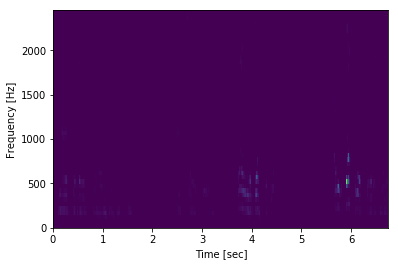

In [64]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [40]:
def log_spectrogram(spectrogram, c):
    return np.log(spectrogram + c)

In [66]:
Sxx_log = log_spectrogram(Sxx, 1.0E-7)

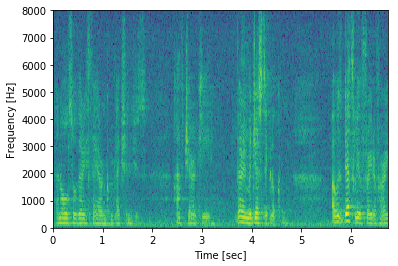

In [68]:
plt.pcolormesh(t, f, test_spec)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

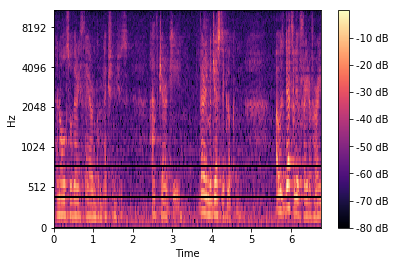

In [81]:
#Mel spectrogram
S = librosa.feature.melspectrogram(samples, sr=sampling_rate, n_fft=window_size, hop_length=stride_size, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sampling_rate, hop_length=stride_size, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [83]:
S.shape

(128, 677)

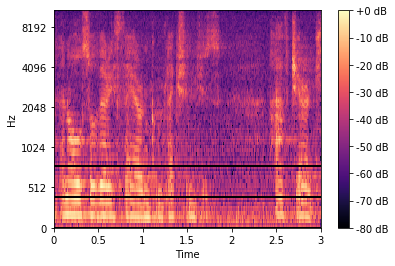

In [85]:
#Mel spectrogram
S = librosa.feature.melspectrogram(samples[:48000], sr=sampling_rate, n_fft=window_size, hop_length=stride_size, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sampling_rate, hop_length=stride_size, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [86]:
S.shape

(128, 301)

In [87]:
import sys
sys.getsizeof(S)

154224

In [89]:
154224.0 * 48841.0 / 1000000000 

7.532454384